In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies import ImpalaCNN

def make_procgen_env(env_name, num_envs=1, start_level=0, num_levels=0):
    def _init():
        
        return env
    return DummyVecEnv([_init] * num_envs)

env_name = "procgen:procgen-heist-v0"  



env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



In [2]:
def load_model(model_path = '../model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


In [3]:
@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action


In [82]:
import torch
import imageio



def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observation = env.reset()
    done = False
    total_reward = 0
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= 200:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames 


save_gif_option = True  



In [83]:

model = load_model()
frames = []
observations =[]
for episode in range(1):
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, _ = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")







Episode 1 finished with total reward: 10.0


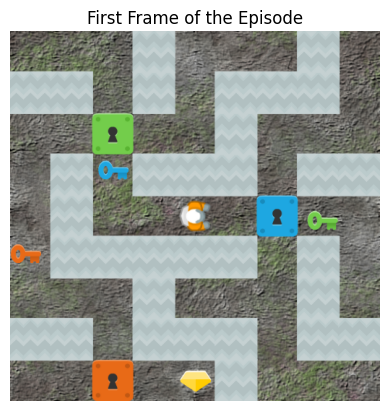

In [80]:
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")

In [84]:
import imageio

def create_gif(frames, filename, duration=0.1):
    # Convert frames to uint8
    # frames = [(frame * 255).astype(np.uint8) for frame in frames]
    

    # Write frames to GIF file
    imageio.mimsave(filename, frames, duration=duration)


create_gif(frames, "episode_gif.gif")


In [26]:
observations[0].shape

(64, 64, 3)

In [30]:
observations[0]

array([[[107, 100,  94],
        [ 94,  89,  84],
        [ 98,  96,  91],
        ...,
        [101,  96,  90],
        [ 95,  90,  85],
        [ 96,  90,  87]],

       [[ 50,  47,  43],
        [ 73,  71,  67],
        [ 92,  92,  80],
        ...,
        [ 82,  73,  70],
        [ 75,  68,  65],
        [ 67,  62,  59]],

       [[ 88,  79,  76],
        [109, 105,  99],
        [102,  99,  94],
        ...,
        [104,  99,  94],
        [ 84,  81,  76],
        [ 66,  60,  57]],

       ...,

       [[ 96,  96,  94],
        [120, 114, 109],
        [ 87,  80,  78],
        ...,
        [138, 138, 138],
        [104, 104, 102],
        [ 86,  86,  82]],

       [[ 82,  81,  78],
        [ 96,  91,  87],
        [ 81,  74,  71],
        ...,
        [123, 123, 120],
        [ 88,  86,  81],
        [ 80,  78,  74]],

       [[ 63,  57,  54],
        [ 85,  82,  78],
        [ 72,  66,  64],
        ...,
        [110, 107, 102],
        [114, 110, 103],
        [ 78,  75,  71]]

In [68]:
def colour_swap(observation):
    blue_key_colors = [
        [27, 177, 232],
        [20, 150, 198],
        [22, 161, 212]
    ]
    green_key_colors = [
        [125, 212, 70],
        [98, 189, 34],
        [110, 195, 56]
    ]

    # Create a copy of the observation array to modify
    modified_observation = observation.copy()

    # Swap the colors of blue and green keys
    for blue_color, green_color in zip(blue_key_colors, green_key_colors):
        # Find pixels that match the blue color within a tolerance
        blue_mask = np.abs(observation - blue_color).sum(axis=-1) < 65
        modified_observation[blue_mask] = green_color

        # Find pixels that match the green color within a tolerance
        green_mask = np.abs(observation - green_color).sum(axis=-1) < 65
        modified_observation[green_mask] = blue_color
    
    return modified_observation

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heist_observation(observation):
    # Define the colors to swap
    blue_key_colors = [
        [27, 177, 232],
        [20, 150, 198],
        [22, 161, 212]
    ]
    green_key_colors = [
        [125, 212, 70],
        [98, 189, 34],
        [110, 195, 56]
    ]

    # Create a copy of the observation array to modify
    modified_observation = observation.copy()

    # Swap the colors of blue and green keys
    for blue_color, green_color in zip(blue_key_colors, green_key_colors):
        # Find pixels that match the blue color within a tolerance
        blue_mask = np.abs(observation - blue_color).sum(axis=-1) < 65
        modified_observation[blue_mask] = green_color

        # Find pixels that match the green color within a tolerance
        green_mask = np.abs(observation - green_color).sum(axis=-1) < 65
        modified_observation[green_mask] = blue_color

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the modified observation
    ax.imshow(modified_observation)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()

In [64]:
[27, 177, 232] in observations[0]

True

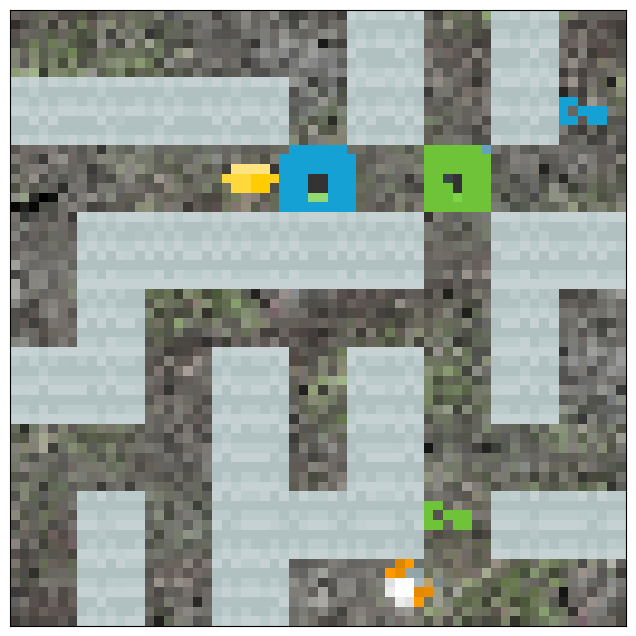

In [65]:
# observation = env.render(mode='rgb_array')  # Get the RGB observation

# Plot the observation
plot_heist_observation(observations[0])

In [67]:
import torch

activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook


model = load_model()

# Define a function to recursively register hooks based on a path
def register_hook_by_path(model, path, name):
    elements = path.split('.')
    for i, element in enumerate(elements):
        if '[' in element:
            # Splitting at '[' and removing the closing ']' to get the index
            base, index = element.replace(']', '').split('[')
            index = int(index)  # Convert index to integer
            model = getattr(model, base)[index]
        else:
            model = getattr(model, element)
        # If we are at the last element, register the hook
        if i == len(elements) - 1:
            model.register_forward_hook(get_activation(name))

# List of layer paths to hook, based on your initial list
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

# Register hooks for each path
for path in layer_paths:
    register_hook_by_path(model, path, path.replace('.', '_'))

# Run your data through the model
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)


output = model(observation)

# Now, activations['layer1'] contains the activations from layer1


In [68]:
def plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=None):
    # Check if the specified layer's activations are available
    if layer_name not in activations:
        print(f"No activations found for layer: {layer_name}")
        return
    
    # Extract the activation tensor for the specified layer
    activation_tensor = activations[layer_name][0].cpu().numpy()
    
    # Adjust for tensors that are 3D (missing batch dimension)
    if activation_tensor.ndim == 3:
        activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
    
    # Determine the number of activation maps (filters) for this layer
    num_activations = activation_tensor.shape[1]
    
    # Calculate grid size
    grid_size = math.ceil(math.sqrt(num_activations))
    
    # Create a figure with dynamic subplots based on the number of activations
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    
    # Initialize an index for activation maps
    activation_idx = 0
    
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            
            # Plot the activation map if we haven't gone through all of them yet
            if activation_idx < num_activations:
                ax.imshow(activation_tensor[0, activation_idx, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'Filter {activation_idx+1}', fontsize=8)
                activation_idx += 1
            else:
                ax.axis('off')  # Hide axes without data
            
            ax.axis('off')  # Hide axes for all plots for a cleaner look
    
    plt.tight_layout()
    
    # Save or show the plot
    if save_filename:
        plt.savefig(save_filename)
        plt.close()
    else:
        plt.show()

In [71]:
import matplotlib.pyplot as plt

def plot_all_layer_activations(activations, layer_names, max_cols=None, save_filename=None):
    # Determine the maximum number of filters across the specified layers
    max_filters = 0
    for layer_name in layer_names:
        if layer_name in activations:
            tensor_shape = activations[layer_name][0].shape
            num_filters = tensor_shape[0] if len(tensor_shape) == 3 else tensor_shape[1]
            if num_filters > max_filters:
                max_filters = num_filters
    max_filters = min(max_filters, max_cols) if max_cols is not None else max_filters
    
    # Create a figure with subplots
    num_layers = len(layer_names)
    fig, axes = plt.subplots(num_layers, max_filters, figsize=(max_filters * 2, num_layers * 2))
    
    for i, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue
        
        activation_tensor = activations[layer_name][0].cpu().numpy()
        # Adjust for tensors that are 3D (missing batch dimension)
        if activation_tensor.ndim == 3:
            activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
        
        num_filters = activation_tensor.shape[1]
        
        for j in range(max_filters):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            if j < num_filters:
                # Plot the activation map for filter j
                ax.imshow(activation_tensor[0, j, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'{layer_name}\nFilter {j+1}', fontsize=8)
                ax.axis('off')
            else:
                # Hide axes without data
                ax.axis('off')
    
    plt.tight_layout()

    if save_filename:
        plt.savefig(save_filename)
        plt.close() 
    else:
        plt.show()
        plt.show()

layer_names = [
    # 'conv_seqs_0_conv',
    # 'conv_seqs_0_res_block0_conv0',
    # 'conv_seqs_0_res_block0_conv1',
    # 'conv_seqs_0_res_block1_conv0',
    # 'conv_seqs_0_res_block1_conv1',
    # 'conv_seqs_1_conv',
    # 'conv_seqs_1_res_block0_conv0',
    # 'conv_seqs_1_res_block0_conv1',
    # 'conv_seqs_1_res_block1_conv0',
    # 'conv_seqs_1_res_block1_conv1',
    # 'conv_seqs_2_conv',
    # 'conv_seqs_2_res_block0_conv0',
    # 'conv_seqs_2_res_block0_conv1',
    # 'conv_seqs_2_res_block1_conv0',
    'conv_seqs_2_res_block1_conv1',
    # 'max_pool2d'
]


for i, observation in enumerate(observations):
    # Run your data through the model
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    activations = {}
    output = model(observation)
    plot_layer_activations_dynamic_grid(activations, 'conv_seqs_2_conv',  save_filename=f"../activation_plot_frames/episode_{i}_plot_later.png")
    # plot_all_layer_activations(activations, layer_names, max_cols=20, save_filename=f"../activation_plot_frames/episode_{i}_plot.png")


In [73]:
import glob
import imageio

def create_gif_from_folder(folder_path, gif_filename):
    # Construct the pattern to match the filenames
    pattern = f"{folder_path}/episode_*_plot_.png"
    
    # Use glob to find matching filenames
    filenames = sorted(glob.glob(pattern), key=lambda x: int(x.split('_')[-2]))
    
    # Check if filenames list is not empty
    if not filenames:
        print("No files found matching the pattern. Please check the folder path and naming convention.")
        return
        
    # Create the GIF
    with imageio.get_writer(gif_filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"GIF created successfully: {gif_filename}")

# Example usage:
folder_path = "../activation_plot_frames"  # Adjust this path as needed
gif_filename = "activation_visualization.gif"  # Name of the output GIF file
create_gif_from_folder(folder_path, gif_filename)


/var/folders/58/f16y6j7x0j5d0vv3pvq80c680000gn/T/ipykernel_1680/2114239409.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created successfully: activation_visualization.gif


In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.size()}")

Parameter name: conv_seqs.0.conv.weight, shape: torch.Size([16, 3, 3, 3])
Parameter name: conv_seqs.0.conv.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.1.conv.weight, shape: torch.Size([32, 16, 3, 3])
Parameter name: conv_seqs.1.conv.bias, shape: torch.Size([32])
Parameter name: conv_seqs.1.res_block0.conv0.weight, shape: torch.Size([32, 3